In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [140]:
def plot_results(model, params):
    left, right = min(model.X_train), max(model.X_train)
    r = np.linspace(left, right, 100)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(model.X_train, model.y_train, label="Real data")
    ax[0].scatter(model.X_train, model.fit_function(model.X_train, params), label="Train")
    ax[0].plot(r, model.fit_function(r, params))
    ax[0].set_title("Training set")
    ax[0].legend()

    left, right = min(model.X_test), max(model.X_test)
    r = np.linspace(left, right, 100)
    ax[1].scatter(model.X_test, model.y_test, label="Real data")
    ax[1].scatter(model.X_test, model.fit_function(model.X_test, params), label="Test")
    ax[1].plot(r, model.fit_function(r, params))
    ax[1].set_title("Test set")
    ax[1].legend()
    plt.show()

def get_data(variant):
    if variant < 10:
        variant = '0' + str(variant)
    var = pd.read_excel("DataRegression.xlsx", sheet_name=f"Var{variant}")
    return var['x'].to_numpy(), var['y'].to_numpy()

In [143]:
def var7_func(x, params):
    b1, b2, b3, b4, b5, b6, b7 = params
    return (b1 + b2 * x + b3 * x ** 2 + b4 * x ** 3) / (1 + b5 * x + b6 * x ** + b7 ** 3)

def var12_func(x, params):
    b1, b2, b3, b4 = params
    return b1 - b2 * x - (1 / np.pi) * np.arctan(b3 / (x - b4))

def var16_func(x, params):
    b1, b2, b3 = params
    return (b1 / b2) * np.exp(-0.5 * ((x - b3) / b2) ** 2)

In [142]:
X_var7, y_var7 = get_data(7)

X_var12, y_var12 = get_data(12)

X_var16, y_var16 = get_data(16)

In [135]:
class Model:
    def __init__(self, X, y, regression_function, *, train_split=0.75):
        '''
        Intialize Model class

        X: 1-D array. Features array
        y: 1-D array. Labels array
        train_split: float in (0, 1) 
        regression_funcion: function to be fitted.
        '''
        self.train_test_partition(X, y, train_split)

        self.fit_function = regression_function

    def train_test_partition(self, X, y, train_split):
        '''
        Splitting data into test and train sets
        '''
        n = int(len(X) * train_split)

        data = np.array(list(zip(X, y)))
        np.random.shuffle(data)
        self.X_train, self.y_train = data[:n, 0], data[:n, 1]
        self.X_test, self.y_test = data[n:, 0], data[n:, 1]


    def loss(self, params):
        '''
        Computes loss function
        '''
        y_hat = self.fit_function(x=self.X_train, params=params)
        mse = np.mean((y_hat - self.y_train) ** 2) / 2
        return mse
    
    def test_loss(self, params):
        '''
        Computes loss function on test set
        '''
        y_hat = self.fit_function(x=self.X_test, params=params)
        mse = np.mean((y_hat - self.y_test) ** 2) / 2
        return mse

In [148]:
class PSO:
    def __init__(self, num_pop, num_dim, cognitive, social, bounds, min_velocity, max_velocity):
        '''
        num_pop: number of particles
        num_dim: dimesionality
        cognitive: cognitive component coeficient
        social: social component coeficient
        left_bound: left bound of particles search area
        right_bound right bound of particles search area
        min_velocity: minimal allowed velocity
        max_velocity: maximum allowed velocity
        '''
        assert 0 < cognitive < 4, "Cognitive coeficient must be in (0, 4)"
        assert 0 < social < 4, "Social coeficient must be in (0, 4)"
        assert np.all(max_velocity > 0), "Maximum velocity must be positive"

        self.num_pop = num_pop
        self.num_dim = num_dim

        self.cognitive = cognitive
        self.social = social

        self.left_bound, self.right_bound = bounds[:, 0], bounds[:, 1]

        self.min_velocity = min_velocity
        self.max_velocity = max_velocity

        # Initializing particles
        
        self.positions = np.random.rand(self.num_pop, self.num_dim) * (self.right_bound - self.left_bound) + self.left_bound
        
        self.best_positions = np.copy(self.positions) # initializing best positions as starting positions

        self.velocities = np.random.rand(self.num_pop, self.num_dim) * (self.max_velocity - self.min_velocity) + self.min_velocity

    def clip_position_higer(self, position):
        return np.where(position > self.right_bound, self.right_bound - abs(position - self.right_bound), position)
    
    def clip_positon_low(self, position):
        return np.where(position > self.left_bound, self.left_bound + abs(position - self.left_bound), position)
    
    def main_loop(self, model, num_iter=20, *, verbose=True):
        objective_function = model.loss
        best_fittnes = np.apply_along_axis(objective_function, axis=1,  arr=self.positions)

        leader = np.argmin(best_fittnes)

        # Initializing result variables
        global_minimum_position = self.positions[leader]
        global_minimum_value = np.min(best_fittnes)

        for i in range(num_iter):
            # Random vectors
            r1 = np.random.rand(1, self.num_dim)
            r2 = np.random.rand(1, self.num_dim)

            # Modifying velocities
            self.velocities += (self.cognitive * (self.best_positions - self.positions) * r1 + 
                                    self.social * (global_minimum_position - self.positions) * r2)
            
            self.velocities = np.maximum(self.velocities, self.min_velocity)
            self.velocities = np.minimum(self.velocities, self.max_velocity)
            
            # Modifying positons
            self.positions += self.velocities

            # inverting velocities depending on particle position
            self.velocities = np.where((self.positions < self.left_bound) | (self.best_positions > self.right_bound), -self.velocities, self.velocities)

            # Clipping positions
            self.positions = self.clip_position_higer(self.positions)
            self.positions = self.clip_positon_low(self.positions)

            # Updating personal record
            fittnes = np.apply_along_axis(objective_function, axis=1,  arr=self.positions)

            # Updating postions
            for j in range(self.num_pop):
                if fittnes[j] < best_fittnes[j]:
                    self.best_positions[j] = self.positions[j]

            best_fittnes = np.minimum(best_fittnes, fittnes)
            
            leader = np.argmin(best_fittnes)


            # Upadating result
            if global_minimum_value > objective_function(self.positions[leader]) and not np.isinf(best_fittnes[leader]):
                global_minimum_position = np.copy(self.positions[leader])
                global_minimum_value = objective_function(self.positions[leader])

            if verbose:
                print("Ітерація %i\nЗначення %.3f\nТочка %s\n" % (i + 1, global_minimum_value, global_minimum_position))


        return np.squeeze(global_minimum_position)
    

In [159]:
class DE:
    def __init__(self, num_pop, num_dim, bounds):
        self.num_pop, self.num_dim = num_pop, num_dim
        self.left_bound, self.right_bound = bounds[:, 0], bounds[:, 1]
        self.population = np.random.rand(self.num_pop, self.num_dim) * (self.right_bound - self.left_bound) + self.left_bound

    def main_loop(self, num_iter, F, P, model, *, verbose=True):
        best_res = np.inf
        best_pos = None

        for i in range(num_iter):
            for pos in range(self.num_pop):
                p1, p2, p3 = np.random.choice(self.num_pop, 3)

                while p1 == p2 or p2 == p3 or p1 == p3:
                    p1, p2, p3 = np.random.choice(self.num_pop, 3)

                x1, x2, x3 = self.population[[p1, p2, p3]]
                v = x1 + F * (x2 - x3)

                # v = np.where(np.random.rand(self.num_dim, ) < P, self.population[pos], v)

                for j in range(self.num_dim):
                    if np.random.rand() < P:
                        v[j] = self.population[pos][j]

                if model.loss(v) < model.loss(self.population[pos]):
                    self.population[pos] = v.copy()

            fitness = np.apply_along_axis(model.loss, 1, self.population)
            min_ind = fitness.argmin()

            if fitness[min_ind] < best_res:
                best_res = fitness[min_ind].copy()
                best_pos = self.population[min_ind].copy()

            if verbose:
                print("Ітерація %i\nЗначення %.3f\nТочка %s\n" % (i + 1, best_res, best_pos))

        return best_pos

In [149]:
bounds_var12 = np.array([
    (-1, 1), (-1, 1), (1000, 2000), (-200, 200)
])
model = Model(X_var12, y_var12, var12_func)
test = PSO(100, len(bounds_var12), 1, 3, bounds_var12, -1e-1, 1e-1)
params_var12 = test.main_loop(model, 500, verbose=False)
print("Loss on train set %.3e\nLoss on test set %.3e" % (model.loss(params_var12), model.test_loss(params_var12)))

Loss on train set 1.052e-04
Loss on test set 8.250e-05


In [163]:
test_e = DE(100, len(bounds_var12), bounds_var12)
p_var12 = test_e.main_loop(500, 1, 0.5, model, verbose=False)
print("Loss on train set %.3e\nLoss on test set %.3e" % (model.loss(p_var12), model.test_loss(p_var12)))

Loss on train set 7.639e-04
Loss on test set 8.976e-04


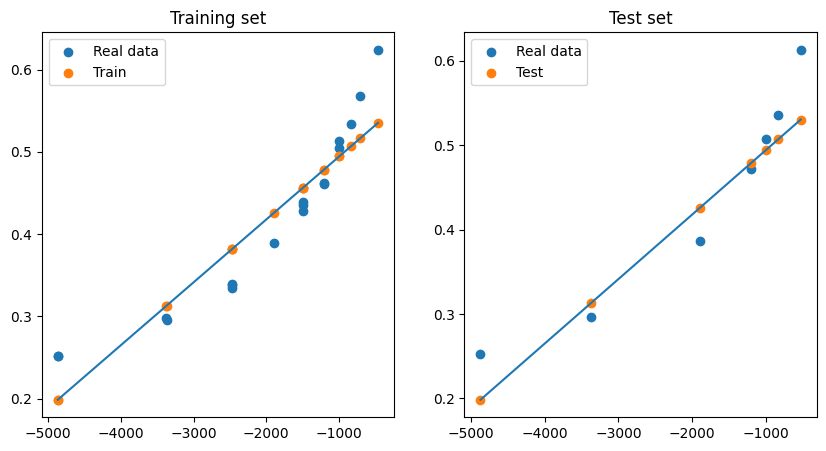

In [164]:
plot_results(model, p_var12)